<a href="https://colab.research.google.com/github/baerenstein/shesh/blob/master/Option_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Options

Below is a collection of simple options trading strategies and algorithms provided by [QuantConnect](https://www.quantconnect.com/learning/articles/applied-options)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta

# Bull Call Spread

## Definition
Bull Call Spread is an options strategy involving two call option contracts with the same expiration but different strikes. The strategy buys one call option with a lower strike and sells another call option with a higher strike price.

This strategy creates a ceiling and floor for the profit. By purchasing a call and selling a call with higher strike simultaneously, traders can reduce the cost of just one long call option with the premium of a short call option. But the premium of ITM call is more expensive than the OTM call. The strategy limits the loss resulting from a drop in the price of the underlying stock but still creates a ceiling to the profit while the underlying price is increasing.

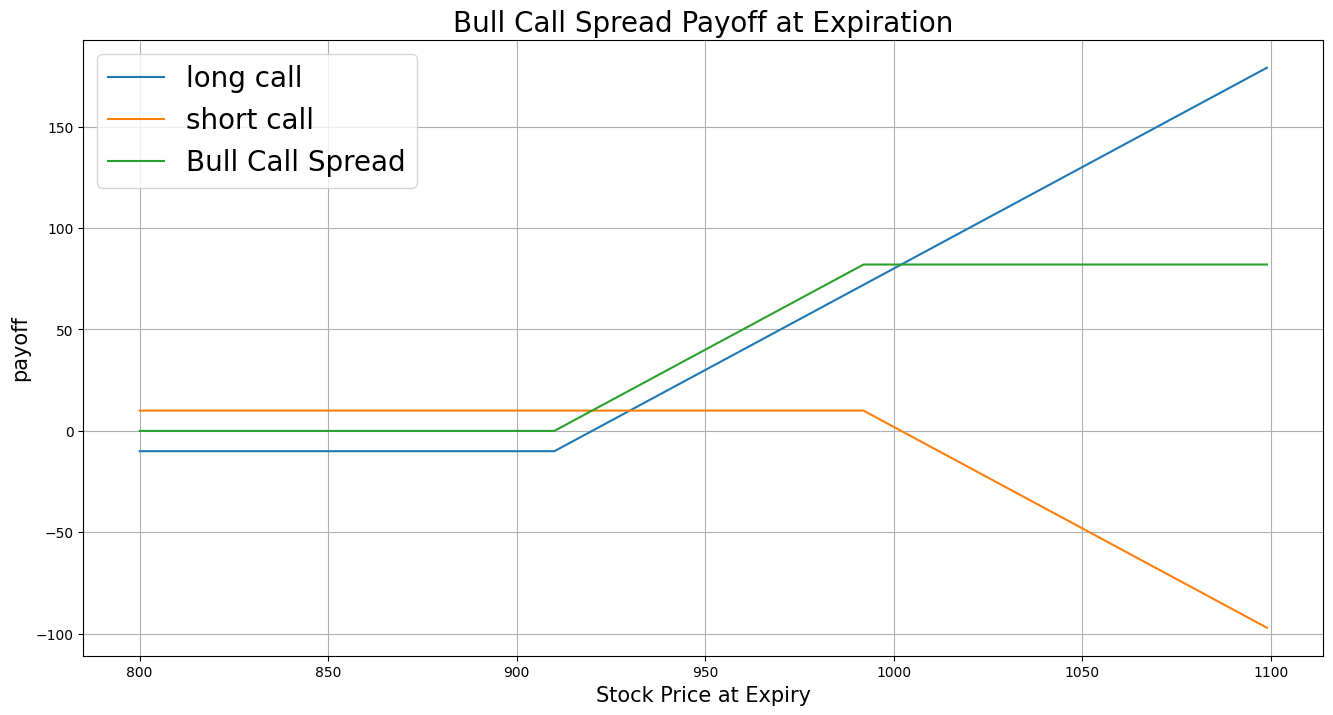

In [ ]:
price = np.arange(800,1100,1)

k_low = 900   # lower strike price for call
k_high = 1000 # higher strike price for call

premium = 10
premium_low = 20 # premium of call option with lower strike
premium_high = 2 # premium of call option with higher strike

payoff_long_call = [max(-premium, i-k_low-premium_low ) for i in price]     # long call with lower strike
payoff_short_call = [min(premium, -(i-k_high-premium_high)) for i in price] # short call with higher strike
payoff = np.sum([payoff_long_call, payoff_short_call], axis=0)              # payoff for Bull Call Spread Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_call, label = 'long call')
plt.plot(price, payoff_short_call, label = 'short call')
plt.plot(price, payoff, label = 'Bull Call Spread')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Bull Call Spread Payoff at Expiration',fontsize = 20)
plt.grid(True)

## Implementation
Step 1: First, you need to initialize the algorithm including set the start date, end date and the cash required. Then use option.SetFilter(-6, 6, 30, 60) to filter the candidate contracts which expire in 30 days to 60 days from now on. The strike price range involves both ITM and OTM options. Then we get the option chains of GOOG.

Step 1(b): use the self.Portfolio.Invested method in the OnData(self,slice) method because you only need to trade options once and wait until the contracts expire. If you already had securities invested in the portfolio, then you do not need to trade new options.

Step 2: Choose the contracts with the same expiration date. For demonstration purpose here we sorted the contracts by their expiration dates and choose the options with the furthest expiration date in the option chain.

Step 3: Filter the call options from the contracts which expire on the furthest expiration date in the option chain.

Step 4: Sort the call options with the same expiration date according to their strike price. Then buy the call option with the lowest strike price and sell the call with the highest strike price.

### Backtest (SetFilter)

In [ ]:
class BullCallSpreadAlgorithm(QCAlgorithm):

    # Step 1
    def Initialize(self):

        self.SetStartDate(2016, 5, 1)
        self.SetEndDate(2016, 10, 1)
        self.SetCash(200000)

        equity = self.AddEquity("GOOG")
        option = self.AddOption("GOOG")
        self.symbol = option.Symbol
        option.SetFilter(-6, 6, 30, 60)   # set our strike/expiry filter for this option chain

        self.SetBenchmark(equity.Symbol)  # use the underlying equity GOOG as the benchmark

    # Step 1 (b)
    def OnData(self,slice):

      if self.Portfolio.Invested:
        return

      # Step 2
      chain = slice.OptionChains.get(self.symbol)
      expiry = sorted(chain, key=lambda x: x.Expiry, reverse=True)[0].Expiry            # sorted the optionchain by expiration date and choose the furthest date

      # Step 3
      calls = [i for i in chain if i.Expiry == expiry and i.Right == OptionRight.Call]  # filter the call options from the contracts expires on that date

      # Step 4
      calls = sorted(calls, key=lambda x: x.Strike)   # sorted the contracts according to their strike prices
      self.Buy(calls[0].Symbol, 1)                    # Buy call option contract with lower strike
      self.Sell(calls[-1].Symbol, 1)                  # Sell call option contract with higher strike

    def OnOrderEvent(self, orderEvent):
        self.Log(f'{orderEvent}')

### Backtest OptionChainProvider

In [ ]:
class BullCallSpreadAlgorithm(QCAlgorithm):
    # Step 1
    def Initialize(self):
        self.SetStartDate(2017, 5, 1)
        self.SetEndDate(2017, 7, 1)
        self.SetCash(100000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol
        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        ''' OptionChainProvider gets the option chain provider,
            used to get the list of option contracts for an underlying symbol.
            Then you can manually filter the contract list returned by GetOptionContractList.
            The manual filtering will be limited to the information
            included in the Symbol (strike, expiration, type, style) and/or prices from a History call '''

        if not self.Portfolio.Invested:
            self.TradeOptions()


    def TradeOptions(self):
        filtered_contracts = self.InitialFilter(-7, 7, 30, 60)

        # Step 2
        if len(filtered_contracts) > 1:  # sorted the optionchain by expiration date and choose the furthest date
            expiry = sorted(filtered_contracts,key = lambda x: x.ID.Date, reverse=True)[0].ID.Date

            # Step 3
            call = [i for i in filtered_contracts if i.ID.Date == expiry and i.ID.OptionRight == 0]   # filter the call options from the contracts expires on that date
            # Step 4
            call_contracts = sorted(call,key = lambda x: x.ID.StrikePrice)                            # sorted the contracts according to their strike prices
            self.call_low   = call_contracts[0]   # call option contract with lower strike
            self.call_high  = call_contracts[-1]  # call option contract with higher strike

            self.AddOptionContract(self.call_low, Resolution.Minute)
            self.AddOptionContract(self.call_high, Resolution.Minute)

            self.Buy(self.call_low ,1)
            self.Sell(self.call_high ,1)

    def InitialFilter(self, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            according to the range of strike price and the expiration date '''

        contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
        if len(contracts) == 0 : return []

        contract_list = [i for i in contracts if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry] # fitler the contracts based on the expiry range

        atm_strike = sorted(contract_list,    # find the strike price of ATM option
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[self.underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))

        atm_strike_rank = strike_list.index(atm_strike)  # find the index of ATM strike in the sorted strike list
        try:
            strikes = strike_list[(atm_strike_rank + min_strike_rank):(atm_strike_rank + max_strike_rank)]
        except:
            strikes = strike_list
        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice in strikes]

        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

# Long Straddle

## Definition
Long Straddle is an options trading strategy involving the going long in both a call and a put option, where both options have the same underlying asset, strike price and expiration date. This strategy aims to profit from volatile movements in the underlying stock, either positive or negative.

Given this plot, if the stock price moves significantly away from the strike price in either direction, the Long Straddle will profit. The potential profit is unlimited on the upside because the stock price can rise indefinitely. On the downside, the potential profit is substantial but limited since the stock price can't fall below zero. The potential loss is limited to the premium of both call and put options. The maximum loss will be realized if the stock price is exactly equal to the strike price at expiration, and both options will expire worthless.

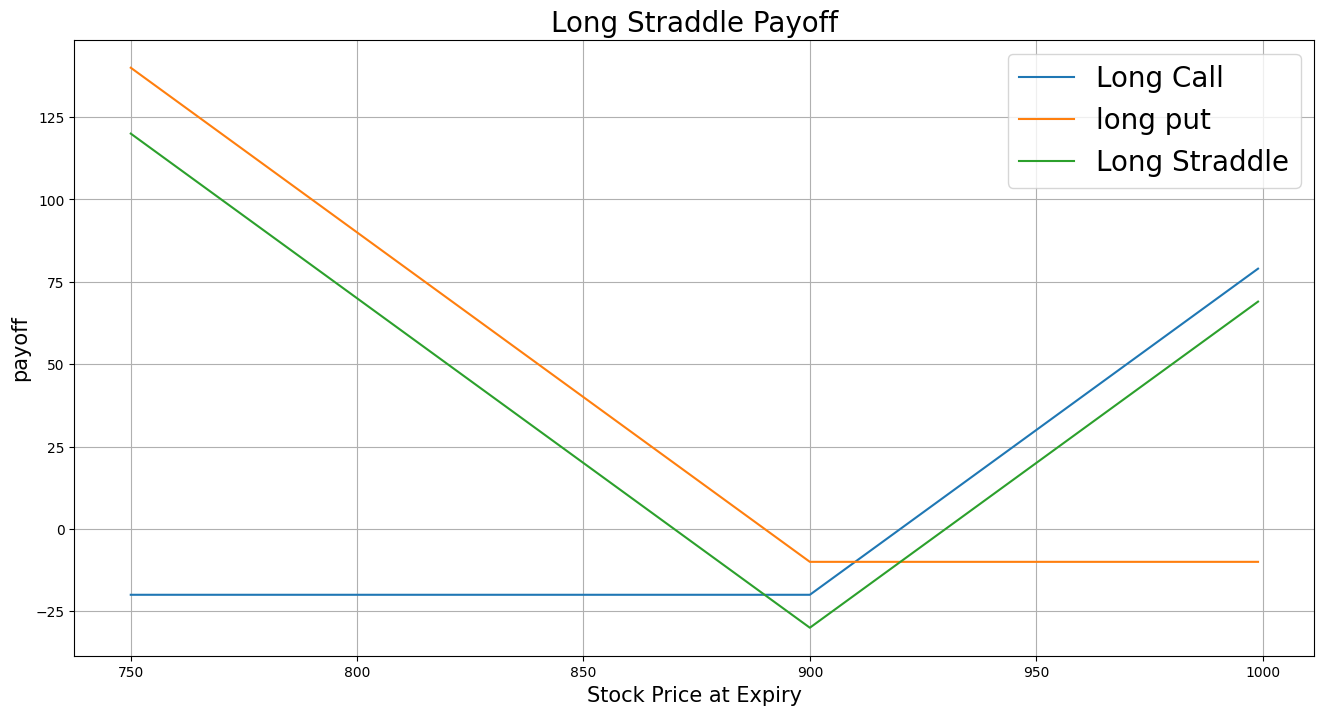

In [ ]:
price = np.arange(750,1000,1)

strike = 900 # strike price for both call and put

premium_call = 20 # premium of call option
premium_put = 10 # premium of put option

payoff_long_call = [max(-premium_call, i-strike-premium_call) for i in price] # payoff for the long call
payoff_long_put = [max(-premium_put, strike-i-premium_put) for i in price]    # payoff for the long put
payoff = np.sum([payoff_long_call, payoff_long_put], axis=0)                  # payoff for Long Straddle Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_call, label = 'Long Call')
plt.plot(price, payoff_long_put, label = 'long put')
plt.plot(price, payoff, label = 'Long Straddle')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Long Straddle Payoff',fontsize = 20)
plt.grid(True)

## Implementation
Step 1: Initialize your algorithm and filter the contract. Here we choose the time to expiration to be between 30 to 60 days.

Step 2: Sort the option chain by expiration and choose the furthest date to filter the call contract. Then sort those call contracts by their strike price and choose the call contracts with the highest strike price to trade.

Step 3: According to the call option contract, choose the put option with the same strike price and the same expiration date. Then buy the call option and the put option at the same time and wait until expiration.

### Backtest (Using SetFilter)

In [ ]:
class LongStraddleAlgorithm(QCAlgorithm):

    # Step 1
    def Initialize(self):
        self.SetStartDate(2017, 4, 01)
        self.SetEndDate(2017, 6, 30)
        self.SetCash(100000)

        equity = self.AddEquity("GOOG", Resolution.Minute)
        option = self.AddOption("GOOG", Resolution.Minute)
        self.symbol = option.Symbol
        option.SetFilter(-5, 5, timedelta(30), timedelta(60))

        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):
        for i in slice.OptionChains:
          chains = i.Value
          if not self.Portfolio.Invested:
            self.TradeOptions(chains)

    def TradeOptions(self, chains):
        # Step 2
        expiry = sorted(chains,key = lambda x: x.Expiry, reverse=True)[0].Expiry          # sorted the optionchain by expiration date and choose the furthest date
        call = [i for i in chains if i.Expiry == expiry and i.Right == OptionRight.Call]  # filter the call and put contract
        put = [i for i in chains if i.Expiry == expiry and i.Right == OptionRight.Put]

        call_contracts = sorted(call,key = lambda x: x.Strike)                            # sorted the contracts according to their strike prices
        if len(call_contracts) == 0: return
        self.call = call_contracts[0]

        # Step 3
        for i in put:
          if i.Strike == self.call.Strike:
            self.put = i
        self.Buy(self.call.Symbol, 1)
        self.Buy(self.put.Symbol ,1)

### Backtest (Using OptionChainProvider)

In [ ]:
class LongStraddleAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 6, 30)
        self.SetCash(100000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol

        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        ''' OptionChainProvider gets the option chain provider,
            used to get the list of option contracts for an underlying symbol.
            Then you can manually filter the contract list returned by GetOptionContractList.
            The manual filtering will be limited to the information
            included in the Symbol (strike, expiration, type, style) and/or prices from a History call '''

        if not self.Portfolio.Invested:
            contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
            self.TradeOptions(contracts)

    def TradeOptions(self,contracts):
        # run CoarseSelection method and get a list of contracts expire within 30 to 60 days from now on
        # and the strike price between rank -5 to rank 5
        filtered_contracts = self.CoarseSelection(self.underlyingsymbol, contracts, -5, 5, 30, 60)
        expiry = sorted(filtered_contracts,key = lambda x: x.ID.Date, reverse=True)[0].ID.Date

        call = [i for i in filtered_contracts if i.ID.Date == expiry and i.ID.OptionRight == 0] # filter the call options from the contracts expire on that date
        call_contracts = sorted(call,key = lambda x: x.ID.StrikePrice)                          # sorted the contracts according to their strike prices
        self.call = call_contracts[0]
        for i in filtered_contracts:
            if i.ID.Date == expiry and i.ID.OptionRight == 1 and i.ID.StrikePrice ==call_contracts[0].ID.StrikePrice:
                self.put = i

        ''' Before trading the specific contract, you need to add this option contract
            AddOptionContract starts a subscription for the requested contract symbol '''

        self.AddOptionContract(self.call, Resolution.Minute)
        self.AddOptionContract(self.put, Resolution.Minute)

        self.Buy(self.call.Value ,1)
        self.Buy(self.put.Value ,1)

    def CoarseSelection(self, underlyingsymbol, symbol_list, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method implements the coarse selection of option contracts
            according to the range of strike price and the expiration date,
            this function will help you better choose the options of different moneyness '''

        # fitler the contracts based on the expiry range
        contract_list = [i for i in symbol_list if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            min_strike = strike_list[atm_strike_rank + min_strike_rank]
            max_strike = strike_list[atm_strike_rank + max_strike_rank]
        except:
            min_strike = strike_list[0]
            max_strike = strike_list[-1]
        # filter the contracts based on the range of the strike price rank
        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice >= min_strike and i.ID.StrikePrice <= max_strike]

        return filtered_contracts

# Iron Butterfly

## Definition
The Iron Butterfly is an option strategy which involves four option contracts, all of which have the same expiration date. The order of strike prices for the four contracts is A > B > C.

>Position	Strike  
>Buy 1 OTM put	 A  
>Sell 1 ATM put	 B  
>Sell 1 ATM call	 B  
>Buy 1 OTM call	 C  

Similar to the Iron Condor, the Iron Butterfly is a limited risk, limited profit trading strategy. It profits from lower volatility, meaning that traders profit if the stock price has marginal movement within a small range. The Iron Butterfly has a more narrow range for the price to move up or down compared with the Iron Condor.

From the payoff plot, the maximum gain is simply the net credit you received when you buy and sell 4 options. This occurs if the stock price is exactly the same as the strike price of the ATM options. In this situation, all options expire worthless and you keep all premiums received. Although the Iron Butterfly has a narrower structure than the Iron Condor, the profit can be higher than with the Iron Condor as you receive a higher premium by selling ATM options than OTM options.

The maximum loss occurs if the underlying price is either below the OTM put strike or above the OTM call strike. In these two situations, two puts or two calls are exercised and the other two options expire worthless.

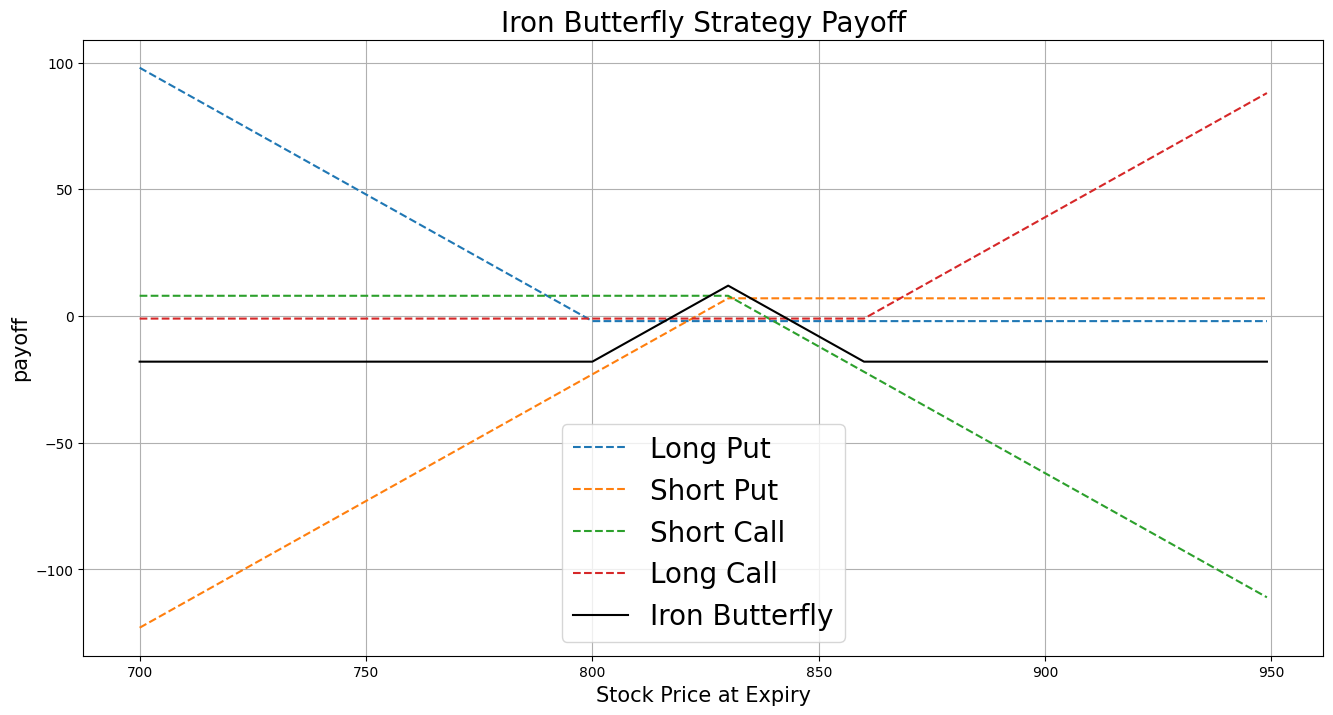

In [ ]:
price = np.arange(700,950,1)

k_atm = 830       # the strike price of ATM call & put
k_otm_put = 800   # the strike price of OTM put
k_otm_call = 860  # the strike price of OTM call

premium_otm_put = 2   # the premium of OTM put
premium_atm_put = 7   # the premium of ATM put
premium_atm_call = 8  # the premium of ATM call
premium_otm_call = 1  # the premium of OTM call

payoff_long_put = [max(-premium_otm_put, k_otm_put-i-premium_otm_put) for i in price]           # payoff for the long put position
payoff_short_put = [min(premium_atm_put, -(k_atm-i-premium_atm_put)) for i in price]            # payoff for the short put position
payoff_short_call = [min(premium_atm_call, -(i-k_atm-premium_atm_call)) for i in price]         # payoff for the short call position
payoff_long_call = [max(-premium_otm_call, i-k_otm_call-premium_otm_call) for i in price]       # payoff for the long call position
payoff = np.sum([payoff_long_put,payoff_short_put,payoff_short_call,payoff_long_call], axis=0)  # payoff for Iron Butterfly Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_put, label = 'Long Put',linestyle='--')
plt.plot(price, payoff_short_put, label = 'Short Put',linestyle='--')
plt.plot(price, payoff_short_call, label = 'Short Call',linestyle='--')
plt.plot(price, payoff_long_call, label = 'Long Call',linestyle='--')
plt.plot(price, payoff, label = 'Iron Butterfly',c='black')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Iron Butterfly Strategy Payoff',fontsize = 20)
plt.grid(True)

## Implementation
Step 1: Initialize your algorithm by setting the start date, end date and the cash. Then, implement the coarse selection of the options contracts.

Step 2: Break the candidate contracts into the call and put options.

Step 3: Sort the call and put options according to their strike prices. option.SetFilter(-10, 10, 0, 30) helps us choose 21 call options and 21 put options which expire within 30 days from now. Then for the call options, the first 10 contracts are in the money and the last 10 contracts are out of the money. The middle one is an at the money option. For the put options, the first 10 contracts are out of the money and the last 10 contracts are in the money.

Step 4: Find the specific contracts to trade. At the money options have the minimum absolute difference between the underlying price and the strike price.

### Backtest using SetFilter

In [ ]:
class IronButterflyAlgorithm(QCAlgorithm):
    # Step 1
    def Initialize(self):

        self.SetStartDate(2017, 2, 1)
        self.SetEndDate(2017, 3, 31)
        self.SetCash(300000)

        equity = self.AddEquity("GOOG", Resolution.Minute)
        option = self.AddOption("GOOG", Resolution.Minute)
        self.symbol = option.Symbol
        option.SetFilter(-10, 10, timedelta(0), timedelta(30))

        self.SetBenchmark(equity.Symbol)  # use the underlying equity GOOG as the benchmark

    def OnData(self, slice):

        if self. Portfolio["GOOG"].Quantity != 0:
          self.Liquidate()

        if not self.Portfolio.Invested and self.Timer.hour != 0 and self.Time.minute !=0:

          # Step 2
          for i in slice.OptionChains:
            if i.Key != self.symbol: continue
            chain = i.Value
            contract_list = [x for x in chain]
            if (slice.OPtionChains.Count == 0) or (len(contract_list) == 0):  # if there is no optionchain or no contracts in this optionchain, pass the instance
              return
            expiry = sorted(chain, key = lambda x: x.Expiry)[-1].Expiry       # sorted the optionchain by expiration date and choose the furthest date
            call  = [i for i in chain if i.Right == 0 and i.Expiry == expiry] # filter  the call options from the contracts
            put   = [i for i in chain if i.Right == 1 and i.Expiry == expiry] # filter  the put options from the contracts

            # Step 3
            call_contracts  = sorted(call, key = lambda x: x.Strike)          # sorted the contracts according to their strike prices
            put_contracts   = sorted(put, key = lambda x: x.Strike)           # sorted the contracts according to their strike prices
            if len(call_contracts) == 0 or len(put_contracts) == 0 : continue

            # Step 4
            atm_put = sorted(put_contracts,key = lambda x: abs(chain.Underlying.Price - x.Strike))[0]   # Sell 1 ATM Put
            self.Sell(atm_put.Symbol ,1)
            atm_call = sorted(call_contracts,key = lambda x: abs(chain.Underlying.Price - x.Strike))[0] # Sell 1 ATM Call
            self.Sell(atm_call.Symbol ,1)
            otm_call = call_contracts[-1] # Buy 1 OTM Call
            self.Buy(otm_call.Symbol ,1)
            otm_put = put_contracts[0]    # Buy 1 OTM Put
            self.Buy(otm_put.Symbol ,1)

            self.trade_contracts = [atm_put, atm_call, otm_call, otm_put]

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))


### Backtest using OptionChainProvider

In [ ]:
class IronButterflyAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 10)
        self.SetCash(10000000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol
        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        if self.Portfolio[self.underlyingsymbol].Quantity != 0:
            self.Liquidate()

        if not self.Portfolio.Invested and self.Time.hour != 0 and self.Time.minute != 0:
            contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
            if len(contracts) == 0 : return
            filtered_contracts = self.InitialFilter(self.underlyingsymbol, contracts, -10, 10, 0, 30)

            expiry = sorted(filtered_contracts, key = lambda x: x.ID.Date)[-1].ID.Date                              # sorted the optionchain by expiration date and choose the furthest date
            call = [i for i in filtered_contracts if i.ID.OptionRight == OptionRight.Call and i.ID.Date == expiry]  # filter the call and put options from the contracts
            put = [i for i in filtered_contracts if i.ID.OptionRight == OptionRight.Put and i.ID.Date == expiry]
            call_contracts = sorted(call,key = lambda x: x.ID.StrikePrice)                                          # sorted the contracts according to their strike prices
            put_contracts = sorted(put,key = lambda x: x.ID.StrikePrice)
            underlyingPrice = self.Securities["GOOG"].Price
            atm_put = sorted(put_contracts,key = lambda x: abs(underlyingPrice - x.ID.StrikePrice))[0]
            atm_call = sorted(call_contracts,key = lambda x: abs(underlyingPrice - x.ID.StrikePrice))[0]
            otm_call = call_contracts[-1]
            otm_put = put_contracts[0]

            self.trade_contracts = [atm_put, atm_call, otm_call, otm_put]
            for contract in self.trade_contracts:
                self.AddOptionContract(contract, Resolution.Minute)

            self.Sell(atm_put ,1)
            self.Sell(atm_call ,1)
            self.Buy(otm_call ,1)
            self.Buy(otm_put ,1)


    def InitialFilter(self, underlyingsymbol, symbol_list, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            based on the range of strike price and the expiration date '''

        if len(symbol_list) == 0 : return
        # fitler the contracts based on the expiry range
        contract_list = [i for i in symbol_list if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            min_strike = strike_list[atm_strike_rank + min_strike_rank]
            max_strike = strike_list[atm_strike_rank + max_strike_rank]

        except:
            min_strike = strike_list[0]
            max_strike = strike_list[-1]

        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice >= min_strike and i.ID.StrikePrice <= max_strike]

        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

# Protective Collar

## Definition
A Protective Collar is an option strategy that involves both the underlying stock and two option contracts. The trader buys (or already owns) a stock, then buys an out-the-money put option and sells an out-the-money call option.  It is similar to the covered call strategy but with the purchase of an additional put option. This strategy is employed if the trader is writing covered calls but wishes to protect himself from an unexpected drop in the price of the underlying security. As a tradeoff for loss-protection, the profit is limited compared with the Covered Call strategy.

According to the payoff plot, the maximum profit is the strike price of short call minus the purchase price of the underlying asset plus the net credit from the premium. It occurs when the underlying price is beyond the strike price of the short call option. The maximum loss is the purchase price of the underlying asset minus the strike price of the long put minus the net credit from the premium. It occurs when the stock price is below the strike price of the long put. It is a strategy with both limited risk and limited profit.

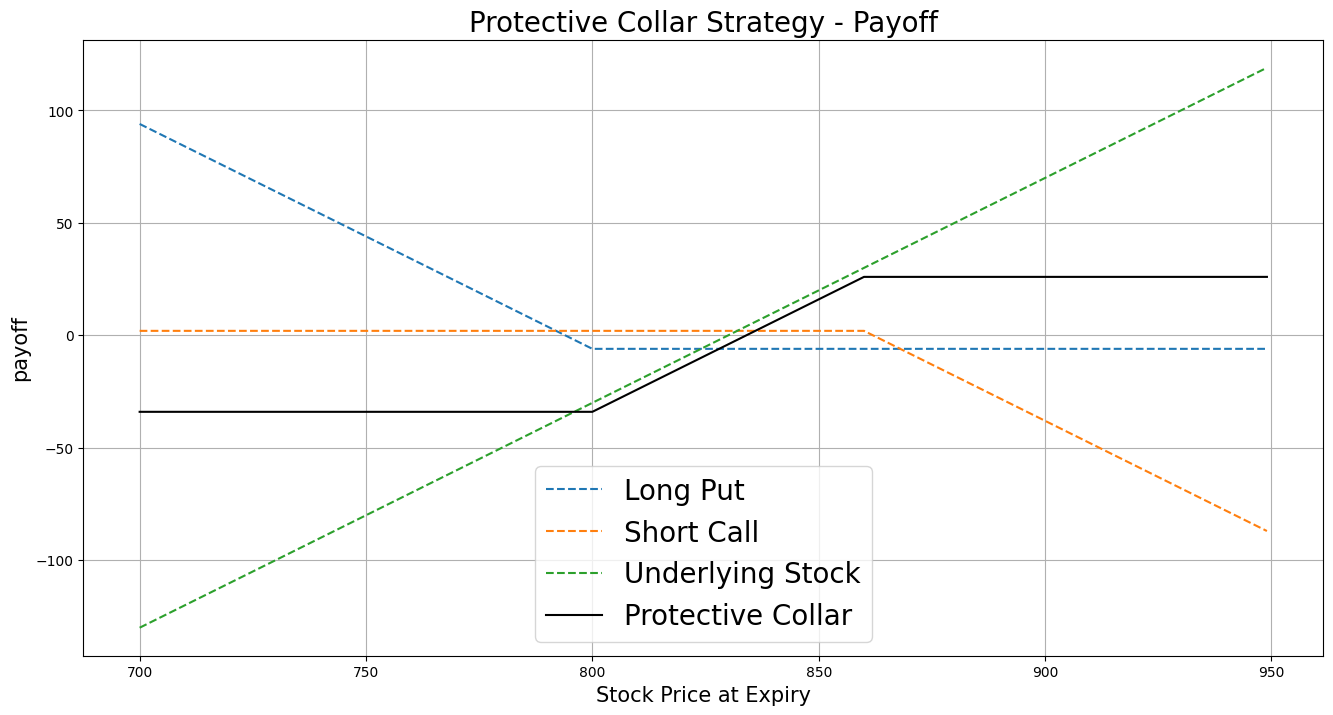

In [ ]:
price = np.arange(700,950,1)

# assume at time 0, the price of the undelying stock is 830
k_otm_put   = 800 # the strike price of OTM put
k_otm_call  = 860 # the strike price of OTM call
premium_otm_put   = 6 # the premium of OTM put
premium_otm_call  = 2 # the premium of OTM call


payoff_long_put   = [max(-premium_otm_put, k_otm_put-i-premium_otm_put) for i in price]       # payoff for the long put position
payoff_short_call = [min(premium_otm_call, -(i-k_otm_call-premium_otm_call)) for i in price]  # payoff for the short call position
payoff_stock = price - 830                                                                    # payoff for the underlying stock
payoff = np.sum([payoff_long_put,payoff_short_call,payoff_stock], axis=0)                     # payoff for Protective Collar Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_put, label = 'Long Put',linestyle='--')
plt.plot(price, payoff_short_call, label = 'Short Call',linestyle='--')
plt.plot(price, payoff_stock, label = 'Underlying Stock',linestyle='--')
plt.plot(price, payoff, label = 'Protective Collar',c='black')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Protective Collar Strategy - Payoff',fontsize = 20)
plt.grid(True)

## Implementation
Step 1: Initialize your algorithm by setting the start date, end date and cash. Then implement the coarse selection of options contracts.

Step 2: Choose the expiration date for your options traded and break the options into the call and put contracts. The choice of expiration date depends on the holding period of stocks in your portfolio.

Step 3: Choose the deep in-the-money call and put options in the list and then sell the call options and buy the put options.

Step 4: In OnData, if there are no assets in our portfolio, we buy the undelying stock. After that, we trade the options written on the same number of shares of underlying asset (one option contracts equals 100 undelying shares).

### Backtest using SetFilter

In [ ]:
class ProtectiveCollarAlgorithm(QCAlgorithm):

    # Step 1
    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 10)
        self.SetCash(10000000)

        equity = self.AddEquity("GOOG", Resolution.Minute)
        option = self.AddOption("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol

        option.SetFilter(-10, +10, timedelta(0), timedelta(30)) # set our strike/expiry filter for this option chain
        self.SetBenchmark(self.underlyingsymbol)                # use the underlying equity as the benchmark

    def OnData(self,slice):

        # Step 4
        if not self.Portfolio[self.underlyingsymbol].Invested:
            self.Buy("GOOG",100)     # buy 100 shares of the underlying stock

        options_invested = [x.Key for x in self.Portfolio if x.Value.Invested and x.Value.Type==SecurityType.Option]
        if len(options_invested) == 0:
            optionchain = slice.OptionChains
            for i in slice.OptionChains:
                chain = i.Value
                contract_list = [x for x in chain]
                if (slice.OptionChains.Count == 0) or (len(contract_list) == 0):
                    return

                # Step 2
                expiry = sorted(chain, key = lambda x: x.Expiry)[-1].Expiry       # choose the furthest expiration date within 30 days from now on
                call = [x for x in chain if x.Right == 0 and x.Expiry == expiry]  # filter the call options contracts
                put = [x for x in chain if x.Right == 1 and x.Expiry == expiry]   # filter the put options contracts

                # Step 3
                self.otm_call = sorted(call, key = lambda x: x.Strike)[-1] # sorted the call options by strike price and choose the deep OTM one in the list
                self.otm_put = sorted(put, key = lambda x: x.Strike)[0]
                if (self.otm_call is None) or (self.otm_put is None): return

                self.Sell(self.otm_call.Symbol, 1)  # sell the OTM call
                self.Buy(self.otm_put.Symbol, 1)    # buy the OTM put
                self.Buy("GOOG",100)                # buy 100 shares of the underlying stock

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

### Backtest using OptionChainProvider

In [ ]:
class ProtectiveCollarAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 10)
        self.SetCash(10000000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol
        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        if not self.Portfolio[self.underlyingsymbol].Invested:
            self.Buy("GOOG",100)     # buy 100 shares of the underlying stock

        options_invested = [x.Key for x in self.Portfolio if x.Value.Invested and x.Value.Type==SecurityType.Option]
        if len(options_invested) == 0:
            contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
            if len(contracts) == 0 : return
            filtered_contracts = self.InitialFilter(self.underlyingsymbol, contracts, -10, 10, 0, 30)

            expiry = sorted(filtered_contracts, key = lambda x: x.ID.Date)[-1].ID.Date              # choose the furthest expiration date within 30 days from now on
            call = [x for x in filtered_contracts if x.ID.OptionRight == 0 and x.ID.Date == expiry] # filter the call options contracts
            put = [x for x in filtered_contracts if x.ID.OptionRight == 1 and x.ID.Date == expiry]  # filter the put options contracts
            self.otm_call = sorted(call, key = lambda x: x.ID.StrikePrice)[-1]                      # sorted the call options by strike price and choose the deep OTM one in the list
            self.otm_put = sorted(put, key = lambda x: x.ID.StrikePrice)[0]
            if (self.otm_call is None) or (self.otm_put is None): return

            self.AddOptionContract(self.otm_call, Resolution.Minute)
            self.AddOptionContract(self.otm_put, Resolution.Minute)

            self.Sell(self.otm_call, 1) # sell the OTM call
            self.Buy(self.otm_put, 1)   # buy the OTM put


    def InitialFilter(self, underlyingsymbol, symbol_list, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            based on the range of strike price and the expiration date '''

        if len(symbol_list) == 0 : return
        # fitler the contracts based on the expiry range
        contract_list = [i for i in symbol_list if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            min_strike = strike_list[atm_strike_rank + min_strike_rank]
            max_strike = strike_list[atm_strike_rank + max_strike_rank]

        except:
            min_strike = strike_list[0]
            max_strike = strike_list[-1]

        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice >= min_strike and i.ID.StrikePrice <= max_strike]

        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

# Butterfly Spread

## Definition

A Butterfly Spread strategy involves trading four option contracts with the same expiration but three different strike prices. There are four kinds of Butterfly Spread:

>Name // Strategy  
>Long butterfly spread with calls // Buy 1 ITM call, sell 2 ATM call, buy 1 OTM call  
>Long butterfly spread with puts // Buy 1 ITM put, sell 2 ATM put, buy 1 OTM put  
>Short butterfly spread with calls // Sell 1 ITM call, buy 2 ATM call, sell 1 OTM call  
>Short butterfly spread with puts // Buy 1 ITM put, sell 2 ATM put, buy 1 OTM put  

A Butterfly Spread consists of three legs with a total of four options. In this tutorial, we use the Long Butterfly Spread as an example: long one ITM call, short two ATM calls and long one OTM call. All the calls have the same expiration. On the other hand, the middle strike is halfway between the lower and the higher strikes.

The aim of a Butterfly Spread strategy is for a trader to profit from marginal price changes in the underlying stock in either direction.

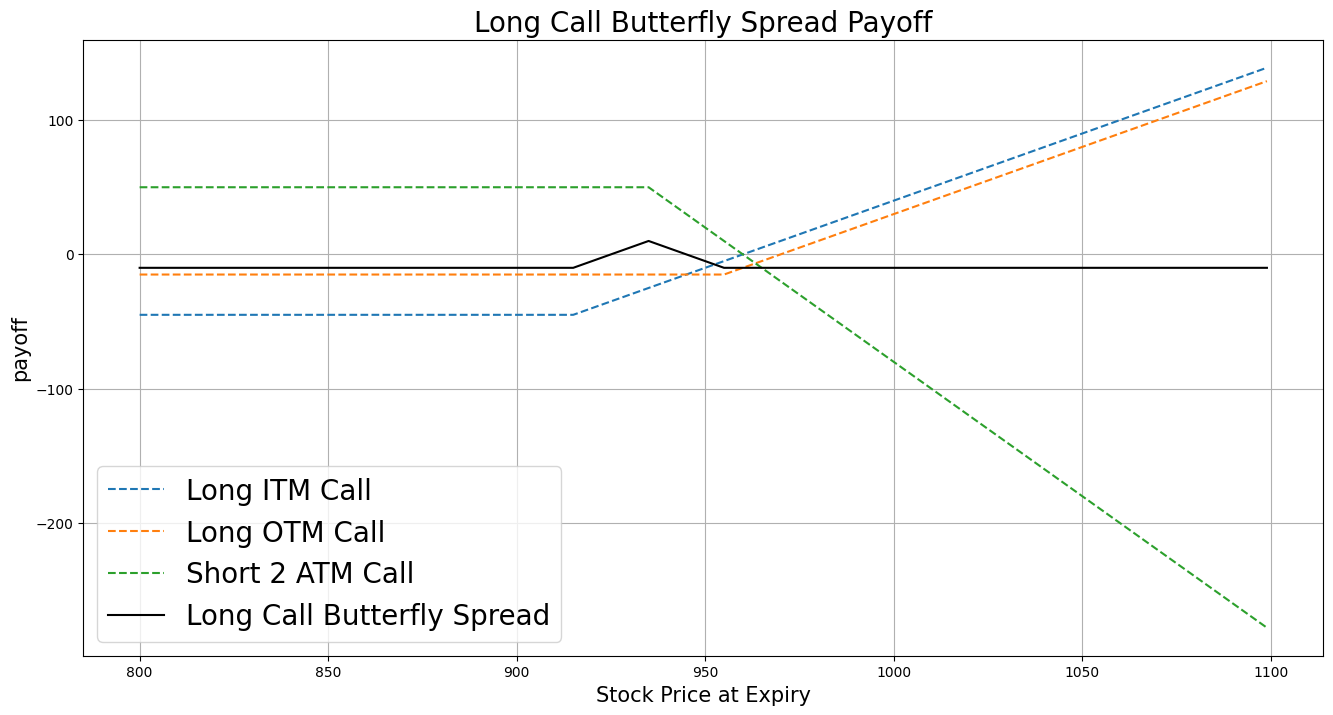

In [10]:
price = np.arange(800,1100,1)

# Suppose the undelying price at time 0 is 935
k_itm = 915 # the strike price of ITM call
k_otm = 955 # the strike price of OTM call
k_atm = 935 # the strike price of ATM call

premium_itm = 45 # the premium of ITM call
premium_otm = 15 # the premium of OTM call
premium_atm = 25 # the premium of ATM call


payoff_itm_long = [max(-premium_itm, i-k_itm-premium_itm) for i in price]         # payoff for the long ITM call position
payoff_otm_long = [max(-premium_otm, i-k_otm-premium_otm) for i in price]         # payoff for the long OTM call position
payoff_atm_short = [min(2*premium_atm, -2*(i-k_atm-premium_atm)) for i in price]  # payoff for the 2 short ATM call position
payoff = np.sum([payoff_itm_long,payoff_otm_long,payoff_atm_short], axis=0)       # payoff for Butterfly Spread Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_itm_long, label = 'Long ITM Call',linestyle='--')
plt.plot(price, payoff_otm_long, label = 'Long OTM Call',linestyle='--')
plt.plot(price, payoff_atm_short, label = 'Short 2 ATM Call',linestyle='--')
plt.plot(price, payoff, label = 'Long Call Butterfly Spread',c='black')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Long Call Butterfly Spread Payoff',fontsize = 20)
plt.grid(True)

## Implementation
Step 1: Initialize your algorithm including setting the start date and the end date, setting the cash and implement a coarse selection of option contract. SetFilter(-9, 9, 30, 60) helps us choose the contracts which expire in 30 to 60 days. For the strike parameter, the first parameter is the minimum strike rank relative to market price,  the second parameter is the maximum strike rank relative to market price.

Step 2: Second we need to choose an expiration date for all the contracts, then filter out all the call options that expire on that date.

Step 3: Sort the call options by their strike price in ascending order. Then choose the ATM option to be the one with the smallest absolute difference between the strike price and the underlying asset price. The OTM option is the last one in the call options list with the highest strike price. The corresponding ITM option is the first one in the list with the lowest strike price.

Step 4: Purchase 1 ITM call option and 1 OTM call option, then sell 2 ATM call option.

### Backtest using SetFilter

In [ ]:
class ButterflySpreadAlgorithm(QCAlgorithm):

    # Step 1
    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 30)
        self.SetCash(150000)
        equity = self.AddEquity("GOOG")
        option = self.AddOption("GOOG")
        self.symbol = option.Symbol

        option.SetFilter(-9, 9, 30, 60)   # set our strike/expiry filter for this option chain
        self.SetBenchmark(equity.Symbol)  # use the underlying equity GOOG as the benchmark

    def OnData(self,slice):

        if self.Portfolio.Invested: # if there is no securities in portfolio, trade the options
            return

        chain = slice.OptionChains.get(self.symbol)
        if not chain:
            return

        # Step 2
        expiry = sorted(chain, key=lambda x: x.Expiry, reverse=True)[0].Expiry            # sorts optionchain by expiration date and choose the furthest date
        calls = [i for i in chain if i.Expiry == expiry and i.Right ==  OptionRight.Call] # filters call options from the contracts expires on that date
        if not calls:
            return

        # Step 3
        calls = sorted(calls, key=lambda x: x.Strike)   # sorts contracts according to their strike prices

        otm_call = calls[-1].Symbol                                                               # choose OTM call
        itm_call = calls[0].Symbol                                                                # choose ITM call
        atm_call = sorted(calls, key=lambda x: abs(chain.Underlying.Price - x.Strike))[0].Symbol  # choose ATM call

        # Step 4
        self.Sell(atm_call, 2)
        self.Buy(itm_call, 1)
        self.Buy(otm_call, 1)

    def OnOrderEvent(self, orderEvent):
        self.Log(f'{orderEvent}')

### Backtest using OptionChainProvider

In [ ]:
class ButterflySpreadAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 30)
        self.SetCash(150000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlying = equity.Symbol
        self.SetBenchmark(equity.Symbol)
        self.itm_call = str()
        self.otm_call = str()
        self.atm_call = str()

    def OnData(self,slice):

        ''' OptionChainProvider gets the option chain provider,
            used to get the list of option contracts for an underlying symbol.
            Then you can manually filter the contract list returned by GetOptionContractList.
            The manual filtering will be limited to the information
            included in the Symbol (strike, expiration, type, style) and/or prices from a History call '''
        if self.Securities.ContainsKey(self.itm_call) and self.Securities.ContainsKey(self.otm_call) and self.Securities.ContainsKey(self.atm_call) and not self.Portfolio.Invested:
            self.Buy(self.itm_call, 1)
            self.Buy(self.otm_call, 1)
            self.Sell(self.atm_call, 2)

        if self.Portfolio[self.underlying].Invested:
            self.Liquidate(self.underlying)

        if not self.Portfolio.Invested:

            filtered_contracts = self.InitialFilter(-9, 9, 30, 60)

            if len(filtered_contracts) < 1: return
            expiry = sorted(filtered_contracts,key = lambda x: x.ID.Date, reverse=True)[0].ID.Date  # sorted the optionchain by expiration date and choose the furthest date
            call = [i for i in filtered_contracts if i.ID.Date == expiry and i.ID.OptionRight == 0] # filter the call options from the contracts expires on that date
            call_contracts = sorted(call,key = lambda x: x.ID.StrikePrice)                          # sorted the contracts according to their strike prices

            self.otm_call = call_contracts[-1]  # choose OTM call
            self.itm_call = call_contracts[0]   # choose ITM call
            undelyingPrice = self.Securities[self.underlying].Price
            self.atm_call = sorted(call_contracts,key = lambda x: abs(undelyingPrice - x.ID.StrikePrice))[0] # choose ATM call

            self.trade_contracts = [self.itm_call, self.otm_call, self.atm_call]
            for i in self.trade_contracts:
                self.AddOptionContract(i, Resolution.Minute)


    def InitialFilter(self, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            according to the range of strike price and the expiration date '''

        contracts = self.OptionChainProvider.GetOptionContractList(self.underlying, self.Time.date())
        if len(contracts) == 0 : return []
        # fitler the contracts based on the expiry range
        contract_list = [i for i in contracts if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[self.underlying].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            strikes = strike_list[(atm_strike_rank + min_strike_rank):(atm_strike_rank + max_strike_rank)]
        except:
            strikes = strike_list
        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice in strikes]
        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

# Long Strangle

## Definition
A Long Strangle is an options trading strategy that involves the simultaneous buying of an out-of-the-money put and an out-of-the-money call with the same underlying stock and expiration date. Similar to a Long Straddle, the Long Strangle has unlimited profit and limited risk, and can be applied if traders think the underlying asset will become volatile and move significantly in either direction. It differs from Long Straddle, however, in that the call strike is above the put strike.

From the payoff plot, the most that you can lose in a Long Strangle is the total premium you pay for holding the long position of both options. The maximum loss occurs when the stock price falls between the strike price of two options, in which case both options are worthless at expiration. The maximum gain of Long Strangle is unlimited for upside move because a stock's price has no maximum threshold.

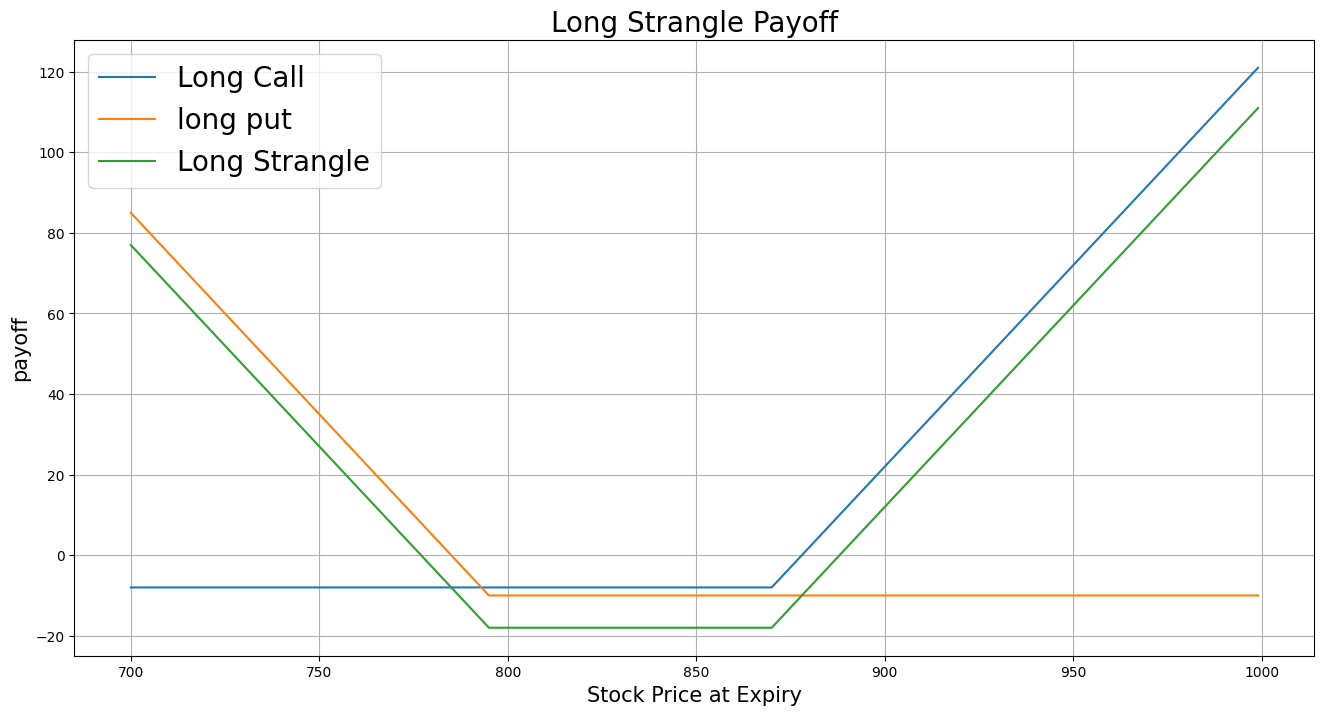

In [2]:
price = np.arange(700,1000,1)

# Suppose the undelying price at time 0 is 830
k_call  = 870   # The strike price of OTM call
k_put   = 795   # The strike price of OTM put
premium_call  = 8   # premium of call option
premium_put   = 10  # premium of put option


payoff_long_call = [max(-premium_call, i-k_call-premium_call) for i in price] # payoff for the long call
payoff_long_put = [max(-premium_put, k_put-i-premium_put) for i in price]     # payoff for the long put
payoff = np.sum([payoff_long_call, payoff_long_put], axis=0)                  # payoff for Long Strangle Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_call, label = 'Long Call')
plt.plot(price, payoff_long_put, label = 'long put')
plt.plot(price, payoff, label = 'Long Strangle')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Long Strangle Payoff',fontsize = 20)
plt.grid(True)

## Implication
Step 1: Initialize your algorithm including setting the start and end date, setting the cash and filtering the options contracts. Note here in SetFilter, the strike price should range from negative to positive because we need to choose out-of-the-money put and call options from candidate contracts. The strike price of OTM call should be greater than ATM options and the strike price of OTM put should be lower than ATM options.

Step 2: Sort the option chain by expiration date and choose an expiration date you want to trade. For demonstration purpose, here we choose options with the furthest expiration date in candidate contracts. Then filter out the call options which expire on that date.

Step 3: Sort the call options by their expiration date and choose the deep OTM contract which has the largest strike price.

Step 4: Select the put options which have the same expiration date with the call option and sort the put options by strike price. Then choose the deep out-of-the-money put which has the minimum strike price among all the available put options.

### Backtest using SetFilter

In [ ]:
class LongStrangleAlgorithm(QCAlgorithm):

    def Initialize(self):

        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 30)
        self.SetCash(100000)

        equity = self.AddEquity("GOOG", Resolution.Minute)
        option = self.AddOption("GOOG", Resolution.Minute)
        self.symbol = option.Symbol
        option.SetFilter(-15, 15, timedelta(30), timedelta(60))

        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):
        optionchain = slice.OptionChains
        for i in slice.OptionChains:
            if i.Key != self.symbol: continue
            chains = i.Value
            contract_list = [x for x in chains]
            # if there is no contracts in this optionchain, pass the instance
            if (slice.OptionChains.Count == 0) or (len(contract_list) == 0): return
             # if there is no securities in portfolio, trade the options
            if not self.Portfolio.Invested:
                self.TradeOptions(optionchain)

    def TradeOptions(self,optionchain):

        for i in optionchain:
            if i.Key != self.symbol: continue

            chain = i.Value
            expiry = sorted(chain,key = lambda x: x.Expiry, reverse=True)[0].Expiry # sorted the optionchain by expiration date and choose the furthest date
            call = [i for i in chain if i.Expiry == expiry and i.Right == 0]        # filter the call options from the contracts expires on that date
            call_contracts = sorted(call,key = lambda x: x.Strike)                  # sorted the contracts according to their strike prices
            if len(call_contracts) == 0: continue

            self.call = call_contracts[-1]  # choose the deep OTM call option
            # select the put options which have the same expiration date with the call option
            put_contracts = sorted([i for i in chain if i.Expiry == expiry and i.Right == 1], key = lambda x: x.Strike) # sort the put options by strike price
            self.put = put_contracts[0]   # choose the deep OTM put option

            self.Buy(self.call.Symbol ,1)
            self.Buy(self.put.Symbol ,1)

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

### Backtest using OptionChainProvider

In [ ]:
class LongStrangleAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 4, 1)
        self.SetEndDate(2017, 5, 30)
        self.SetCash(100000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        self.underlyingsymbol = equity.Symbol
        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        ''' OptionChainProvider gets the option chain provider,
            used to get the list of option contracts for an underlying symbol.
            Then you can manually filter the contract list returned by GetOptionContractList.
            The manual filtering will be limited to the information
            included in the Symbol (strike, expiration, type, style) and/or prices from a History call '''

        if not self.Portfolio.Invested:

            filtered_contracts = self.InitialFilter(-15, 15, 30, 60)
            expiry = sorted(filtered_contracts,key = lambda x: x.ID.Date, reverse=True)[0].ID.Date                  # sorted the optionchain by expiration date and choose the furthest date
            call = [i for i in filtered_contracts if i.ID.Date == expiry and i.ID.OptionRight == OptionRight.Call]  # filter the call options from the contracts expires on that date
            call_contracts = sorted(call,key = lambda x: x.ID.Date)                                                 # sorted the contracts according to their strike prices

            self.call = call_contracts[-1]  # choose the deep OTM call option
            # select the put options which have the same expiration date with the call option
            put_contracts = sorted([i for i in filtered_contracts if i.ID.Date == expiry and i.ID.OptionRight == OptionRight.Put], key = lambda x: x.ID.Date) # sort the put options by strike price
            self.put = put_contracts[0]     # choose the deep OTM put option

            self.AddOptionContract(self.call, Resolution.Minute)
            self.AddOptionContract(self.put, Resolution.Minute)

            self.MarketOrder(self.put, 1)
            self.MarketOrder(self.call, 1)


    def InitialFilter(self, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            according to the range of strike price and the expiration date '''

        contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
        if len(contracts) == 0 : return []
        # fitler the contracts based on the expiry range
        contract_list = [i for i in contracts if min_expiry < (i.ID.Date.date() - self.Time.date()).days < max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[self.underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            strikes = strike_list[(atm_strike_rank + min_strike_rank):(atm_strike_rank + max_strike_rank)]
        except:
            strikes = strike_list
        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice in strikes]

        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

# Iron Condor

## Definition  
An Iron Condor is an option strategy which involves four option contracts. All options have the same expiration date but different strike prices, where generally the spread in the put strike prices is the same as the spread in the calls. The order of strike for four contracts is A > B > C > D.

The Iron Condor is the combination of a bear put spread and a bull call spread in which the strike price of the long put is lower than the strike price of the long call. If the stock price is between the two short strike prices when the options expire, the strategy will be profitable.

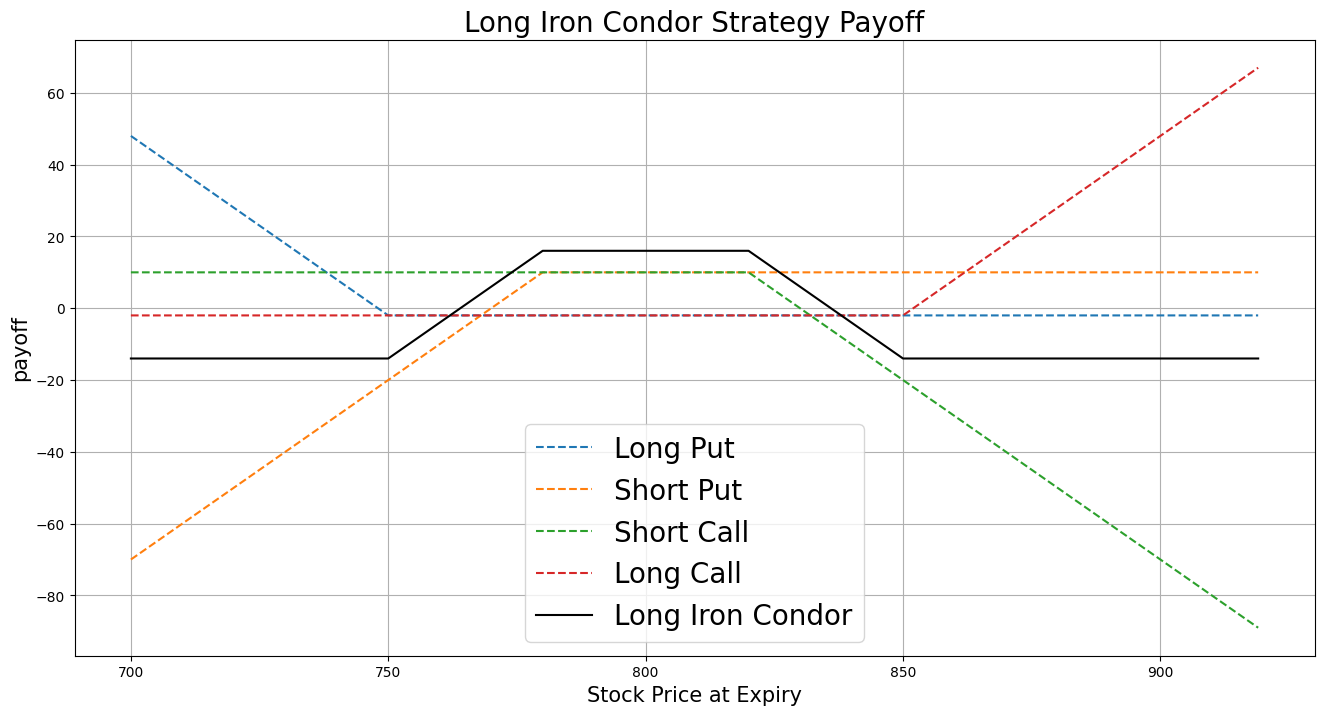

In [ ]:
price = np.arange(700,920,1)
k_call_higher = 850 # the strike price of OTM call(Higher k)
k_call_lower  = 820 # the strike price of OTM call(Lower k)
k_put_higher  = 780 # the strike price of OTM put(Higher k)
k_put_lower   = 750 # the strike price of OTM put(Lower k)
premium_call_higher = 2   # the premium of OTM call(Higher k)
premium_call_lower  = 10  # the premium of OTM call(Lower k)
premium_put_higher  = 10  # the premium of oTM put(Higher k)
premium_put_lower   = 2   # the premium of OTM put(Lower k)


payoff_long_put = [max(-premium_put_lower, k_put_lower-i-premium_put_lower) for i in price]         # payoff for the long put position
payoff_short_put = [min(premium_put_higher, -(k_put_higher-i-premium_put_higher)) for i in price]   # payoff for the short put position
payoff_short_call = [min(premium_call_lower, -(i-k_call_lower-premium_call_lower)) for i in price]  # payoff for the short call position
payoff_long_call = [max(-premium_call_higher, i-k_call_higher-premium_call_higher) for i in price]  # payoff for the long call position
payoff = np.sum([payoff_long_put,payoff_short_put,payoff_short_call,payoff_long_call], axis=0)      # payoff for Long Iron Condor Strategy

plt.figure(figsize=(16,8))
plt.plot(price, payoff_long_put, label = 'Long Put',linestyle='--')
plt.plot(price, payoff_short_put, label = 'Short Put',linestyle='--')
plt.plot(price, payoff_short_call, label = 'Short Call',linestyle='--')
plt.plot(price, payoff_long_call, label = 'Long Call',linestyle='--')
plt.plot(price, payoff, label = 'Long Iron Condor',c='black')
plt.legend(fontsize = 20)
plt.xlabel('Stock Price at Expiry',fontsize = 15)
plt.ylabel('payoff',fontsize = 15)
plt.title('Long Iron Condor Strategy Payoff',fontsize = 20)
plt.grid(True)

## Implementation

Step 1: Initialize your algorithm by setting the start date, the end date and the cash for your algorithm. Then, implement the coarse selection of option contracts.

Step 2: Break the candidate options into two parts: calls and puts.

Step 3: Sort the call and put options by their strike prices.

Step 4: Choose the corresponding options and trade them. In this algorithm, according to criteria, SetFilter(-20, 20, 0, 40) for put option list, there are 41 contracts in total: 1 ATM put, 20 OTM puts and 20 ITM puts. We choose the first in the put option list as the OTM put with the lower strike and the 15th contract as the OTM put with the higher strike.

### Backtest using SetFilter

In [ ]:
class IronCondorAlgorithm(QCAlgorithm):

    def Initialize(self):

        self.SetStartDate(2017, 2, 1)
        self.SetEndDate(2017, 3, 1)
        self.SetCash(500000)

        equity = self.AddEquity("GOOG", Resolution.Minute)
        option = self.AddOption("GOOG", Resolution.Minute)
        self.symbol = option.Symbol
        option.SetFilter(self.UniverseFunc)

        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):
        self.TradeOptions(slice)


    def TradeOptions(self,slice):
        # If there is undelying assets in portfolio at expiration, liquidate the stocks in order to roll into new contracts
        if self.Portfolio["GOOG"].Quantity != 0:
                self.Liquidate()

        if not self.Portfolio.Invested and self.Time.hour != 0 and self.Time.minute != 0:
            for i in slice.OptionChains:
                chain = i.Value
                contract_list = [x for x in chain]
                # if there is no optionchain or no contracts in this optionchain, pass the instance
                if (slice.OptionChains.Count == 0) or (len(contract_list) == 0):
                    return

                expiry  = sorted(chain,key = lambda x: x.Expiry)[-1].Expiry         # sorted the optionchain by expiration date and choose the furthest date
                call    = [i for i in chain if i.Expiry == expiry and i.Right == 0] # filter the call and put options from the contracts
                put     = [i for i in chain if i.Expiry == expiry and i.Right == 1]
                call_contracts = sorted(call,key = lambda x: x.Strike)              # sorted the contracts according to their strike price
                put_contracts = sorted(put,key = lambda x: x.Strike)
                if len(call_contracts) == 0 or len(put_contracts) == 0 : continue

                otm_put_lower = put_contracts[0]
                otm_put   = put_contracts[10]
                otm_call  = call_contracts[-10]
                otm_call_higher = call_contracts[-1]
                self.trade_contracts = [otm_call.Symbol,otm_call_higher.Symbol,otm_put.Symbol,otm_put_lower.Symbol]

                # if there is no securities in portfolio, trade the options
                self.Buy(otm_put_lower.Symbol ,1)
                self.Sell(otm_put.Symbol ,1)
                self.Sell(otm_call.Symbol ,1)
                self.Buy(otm_call_higher.Symbol ,1)

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))

    def UniverseFunc(self, universe):
        return universe.IncludeWeeklys().Strikes(-15, 15).Expiration(timedelta(0), timedelta(40))

### Backtest using OptionCainProvider

In [ ]:
class IronCondorAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2017, 2, 1)
        self.SetEndDate(2017, 3, 1)
        self.SetCash(500000)
        equity = self.AddEquity("GOOG", Resolution.Minute)
        equity.SetDataNormalizationMode(DataNormalizationMode.Raw)
        self.underlyingsymbol = equity.Symbol
        self.SetBenchmark(equity.Symbol)

    def OnData(self,slice):

        ''' OptionChainProvider gets the option chain provider,
            used to get the list of option contracts for an underlying symbol.
            Then you can manually filter the contract list returned by GetOptionContractList.
            The manual filtering will be limited to the information
            included in the Symbol (strike, expiration, type, style) and/or prices from a History call '''
        if self.Portfolio[self.underlyingsymbol].Quantity != 0:
            self.Liquidate()

        if not self.Portfolio.Invested:
            contracts = self.OptionChainProvider.GetOptionContractList(self.underlyingsymbol, self.Time.date())
            self.TradeOptions(contracts)


    def TradeOptions(self,contracts):
        if len(contracts) == 0 : return
        filtered_contracts = self.InitialFilter(self.underlyingsymbol, contracts, -15, 15, 0, 40)
        # sorted the optionchain by expiration date and choose the furthest date
        expiry = sorted(filtered_contracts,key = lambda x: x.ID.Date)[-1].ID.Date

        # filter the call and put options from the contracts
        call = [i for i in filtered_contracts if i.ID.OptionRight == 0 and i.ID.Date == expiry]
        put = [i for i in filtered_contracts if i.ID.OptionRight == 1 and i.ID.Date == expiry]
        # sorted the contracts according to their strike prices
        call_contracts = sorted(call,key = lambda x: x.ID.StrikePrice)
        put_contracts = sorted(put,key = lambda x: x.ID.StrikePrice)

        otm_put_lower = put_contracts[0]
        otm_put = put_contracts[10]
        otm_call = call_contracts[-10]
        otm_call_higher = call_contracts[-1]

        self.trade_contracts = [otm_call,otm_call_higher,otm_put,otm_put_lower]
        for contract in self.trade_contracts:
            self.AddOptionContract(contract, Resolution.Minute)

        self.Buy(otm_put_lower, 1)    # Buy 1 OTM Put
        self.Sell(otm_put, 1)         # Sell 1 OTM Call
        self.Sell(otm_call, 1)        # Sell 1 OTM Call (Higher Strike)
        self.Buy(otm_call_higher, 1)  # Buy 1 OTM Call (Higher Strike)


    def InitialFilter(self, underlyingsymbol, symbol_list, min_strike_rank, max_strike_rank, min_expiry, max_expiry):

        ''' This method is an initial filter of option contracts
            based on the range of strike price and the expiration date '''

        if len(symbol_list) == 0 : return
        # fitler the contracts based on the expiry range
        contract_list = [i for i in symbol_list if min_expiry <= (i.ID.Date.date() - self.Time.date()).days <= max_expiry]
        # find the strike price of ATM option
        atm_strike = sorted(contract_list,
                            key = lambda x: abs(x.ID.StrikePrice - self.Securities[underlyingsymbol].Price))[0].ID.StrikePrice
        strike_list = sorted(set([i.ID.StrikePrice for i in contract_list]))
        # find the index of ATM strike in the sorted strike list
        atm_strike_rank = strike_list.index(atm_strike)
        try:
            min_strike = strike_list[atm_strike_rank + min_strike_rank + 1]
            max_strike = strike_list[atm_strike_rank + max_strike_rank - 1]

        except:
            min_strike = strike_list[0]
            max_strike = strike_list[-1]

        filtered_contracts = [i for i in contract_list if i.ID.StrikePrice >= min_strike and i.ID.StrikePrice <= max_strike]

        return filtered_contracts

    def OnOrderEvent(self, orderEvent):
        self.Log(str(orderEvent))